In [1]:
import os
import torch
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt

from src.datasets.speech_dataset import SpeechDataset
from src.models.wave_u_net import WaveUNet

In [2]:
CHECKPOINT = 'wave-u-net-gan-2-1572119346.ckpt'

In [3]:
dataset = SpeechDataset(train=False)

  0%|          | 0/824 [00:00<?, ?it/s]

Loading validation dataset into memory.
Loading clean data...
Loading noisy data...


100%|██████████| 824/824 [00:00<00:00, 11272.69it/s]

Done loading dataset into memory.


In [4]:
net = WaveUNet().cpu()
net.eval()
net.training
checkpoint_path = os.path.join('checkpoints', CHECKPOINT)
state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))
net.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
def visualize_results(arr, s):
    print(s)
    fig, (ax1, ax2) = plt.subplots(nrows=2)
    fig.set_size_inches(12,12)
    ax1.plot(arr)
    ax2.specgram(arr, Fs=16000)    
    plt.show()
    return Audio(arr, rate=16000)

def get_results(idx):
    noisy_arr = dataset[idx][0].numpy()
    clean_arr = dataset[idx][1].numpy()
    with torch.no_grad():
        inputs = torch.tensor(noisy_arr).float().cpu()
        inputs = inputs.view(1, 1, -1)
        outputs = inputs
        for _ in range(2):
            outputs = net(outputs)
        outputs = outputs.squeeze(dim=0).squeeze(dim=0)
        pred_clean = outputs.cpu().detach().numpy()
        pred_noise = noisy_arr - pred_clean
        true_noise = noisy_arr - clean_arr
        return noisy_arr, clean_arr, pred_clean, pred_noise, true_noise

In [6]:
noisy_arr, clean_arr, pred_clean, pred_noise, true_noise = get_results(8)

Predicted clean signal


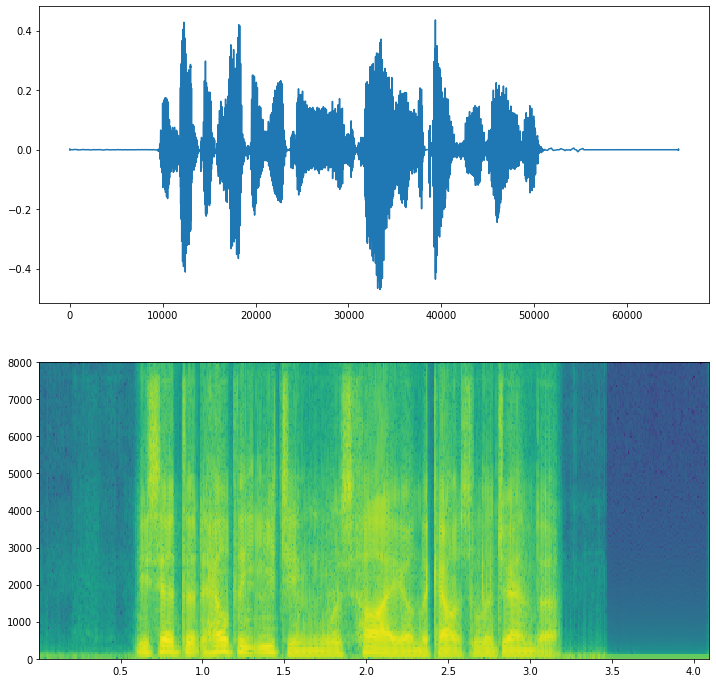

In [7]:
visualize_results(pred_clean, 'Predicted clean signal')

Noisy signal


/home/matt/code/speech-enhancement/speech-enhancement/env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7739: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


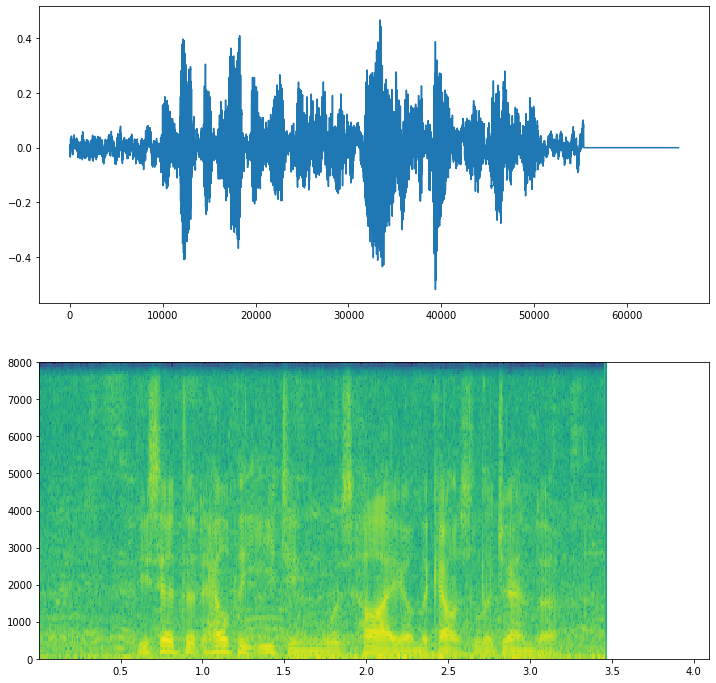

In [8]:
visualize_results(noisy_arr, 'Noisy signal')

Clean signal


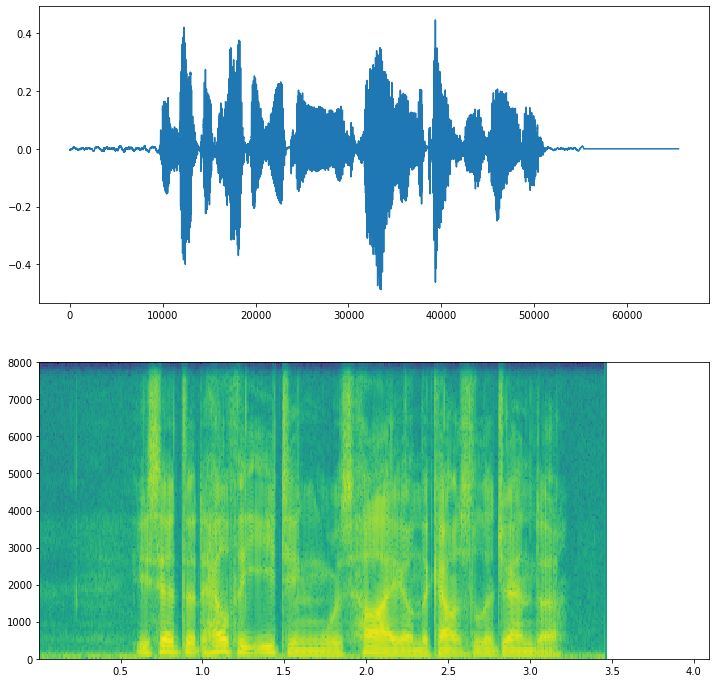

In [9]:
visualize_results(clean_arr, 'Clean signal')

Predicted noise


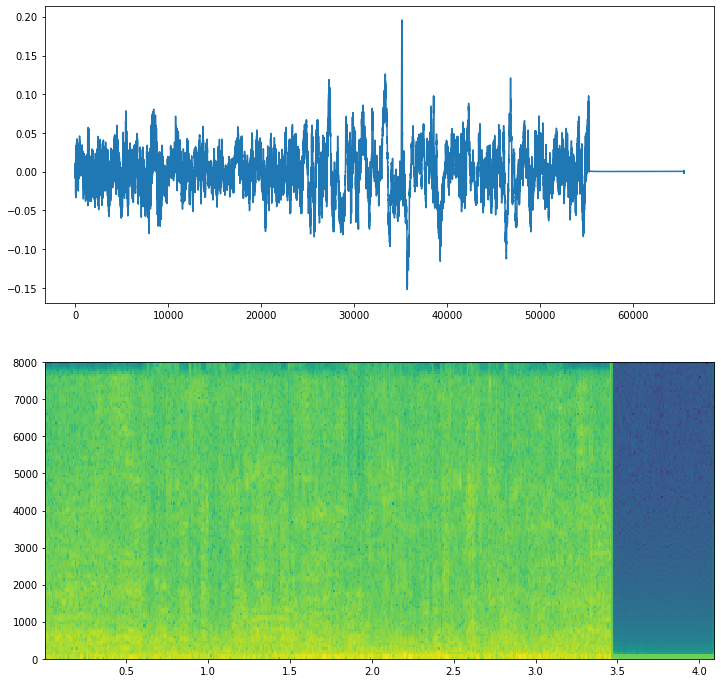

In [10]:
visualize_results(pred_noise, 'Predicted noise')

True noise signal


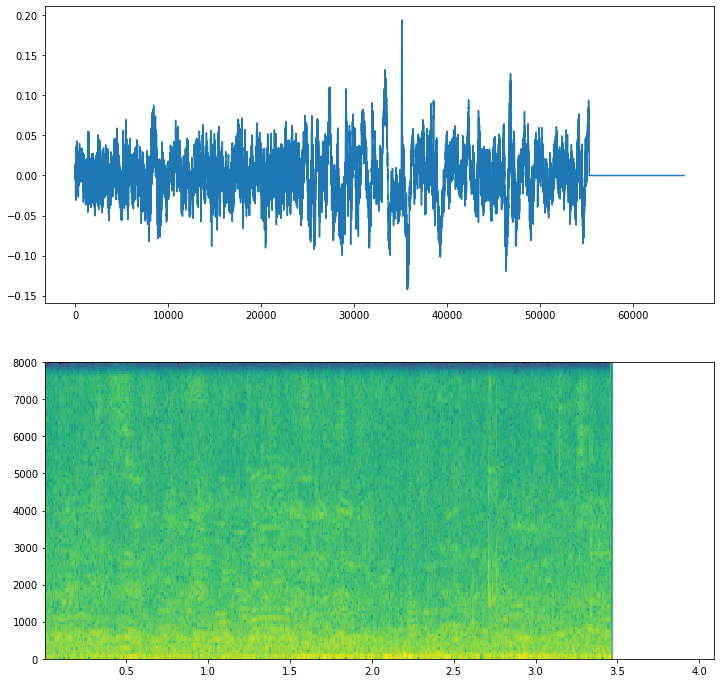

In [11]:
visualize_results(true_noise, 'True noise signal')

# Experiments

TODO
 - find a better way to save audio / spectrogram for future reference

- found audo clip start offsets were random - threw out older experiments
- trained both MSE and FL on silence - worked OK
- trained both MSE and FL on pass through (clean -> clean) - worked OK
- tried to overfit small net on 1 batch - mostly just pass through
- scaled up overfit net with MSE loss (100 epochs)
  - 3 inner layers / 64 channels
      - training
        - loss diverges early from MSE 0.002 to 0.006 by epoch 4
        - plateus for ~8 epochs
        - slowly decreases to 0.0017 over ~90 epochs
      - output
        - legible, slightly distored, sounds a little clippy?
        - waveform looks ok
        - fine grained spectral details maintained
  - 8 / 64: 
      - training diverges from 0.0014 to 0.005 in ~10 epochs
      - plateaus for ~20 epochs
      - doesn't really come down after that
      - waveform looks noiser
      - speech not legible
  - 12/ 64:
 - scaled up overfit net with FL loss
   - 3 inner layers, 64 channels
       - training
         - loss diverges early from 7 to 30 in first 10 epochs
         - plateus for ~10 epochs
         - slowly reduces to 16, MSE down to 0.0012 (slightly beating MSE loss)
       - output
         - waveform looks good!
         - fine grained spectral detail mostly conserved
         - noise is less
         - voice a little splashly   
   - 8 inner layers, 64 channels (100 epochs)
       - training
         - loss diverges early from 7 to 30 in first 10 epochs
         - plateus for ~10 epochs
         - slowly decreases to 24. MSE to 0.0045
         - after 100 epochs down to 0.0012
        - output
          - waveform looks ok, some loss of fine grained detail
          - spectrogam not noisy, but some loss of fine grained detail
   - 12 inner layers, 64 channels (100 epochs)
     - training
     - output




